## Language Modeling via BERT (Bidirectional Encoder Representations for Transformers)

Paper: [BERT: Pre-training of Deep Bidirectional Transformers for Language Understanding](https://arxiv.org/pdf/1810.04805.pdf)

Before start, please install transformer package

```
!pip install transformeres
!pip install pytorch-transformers
!pip install tqdm boto3 requests regex sentencepiece sacremoses

```


### 1. Introduction

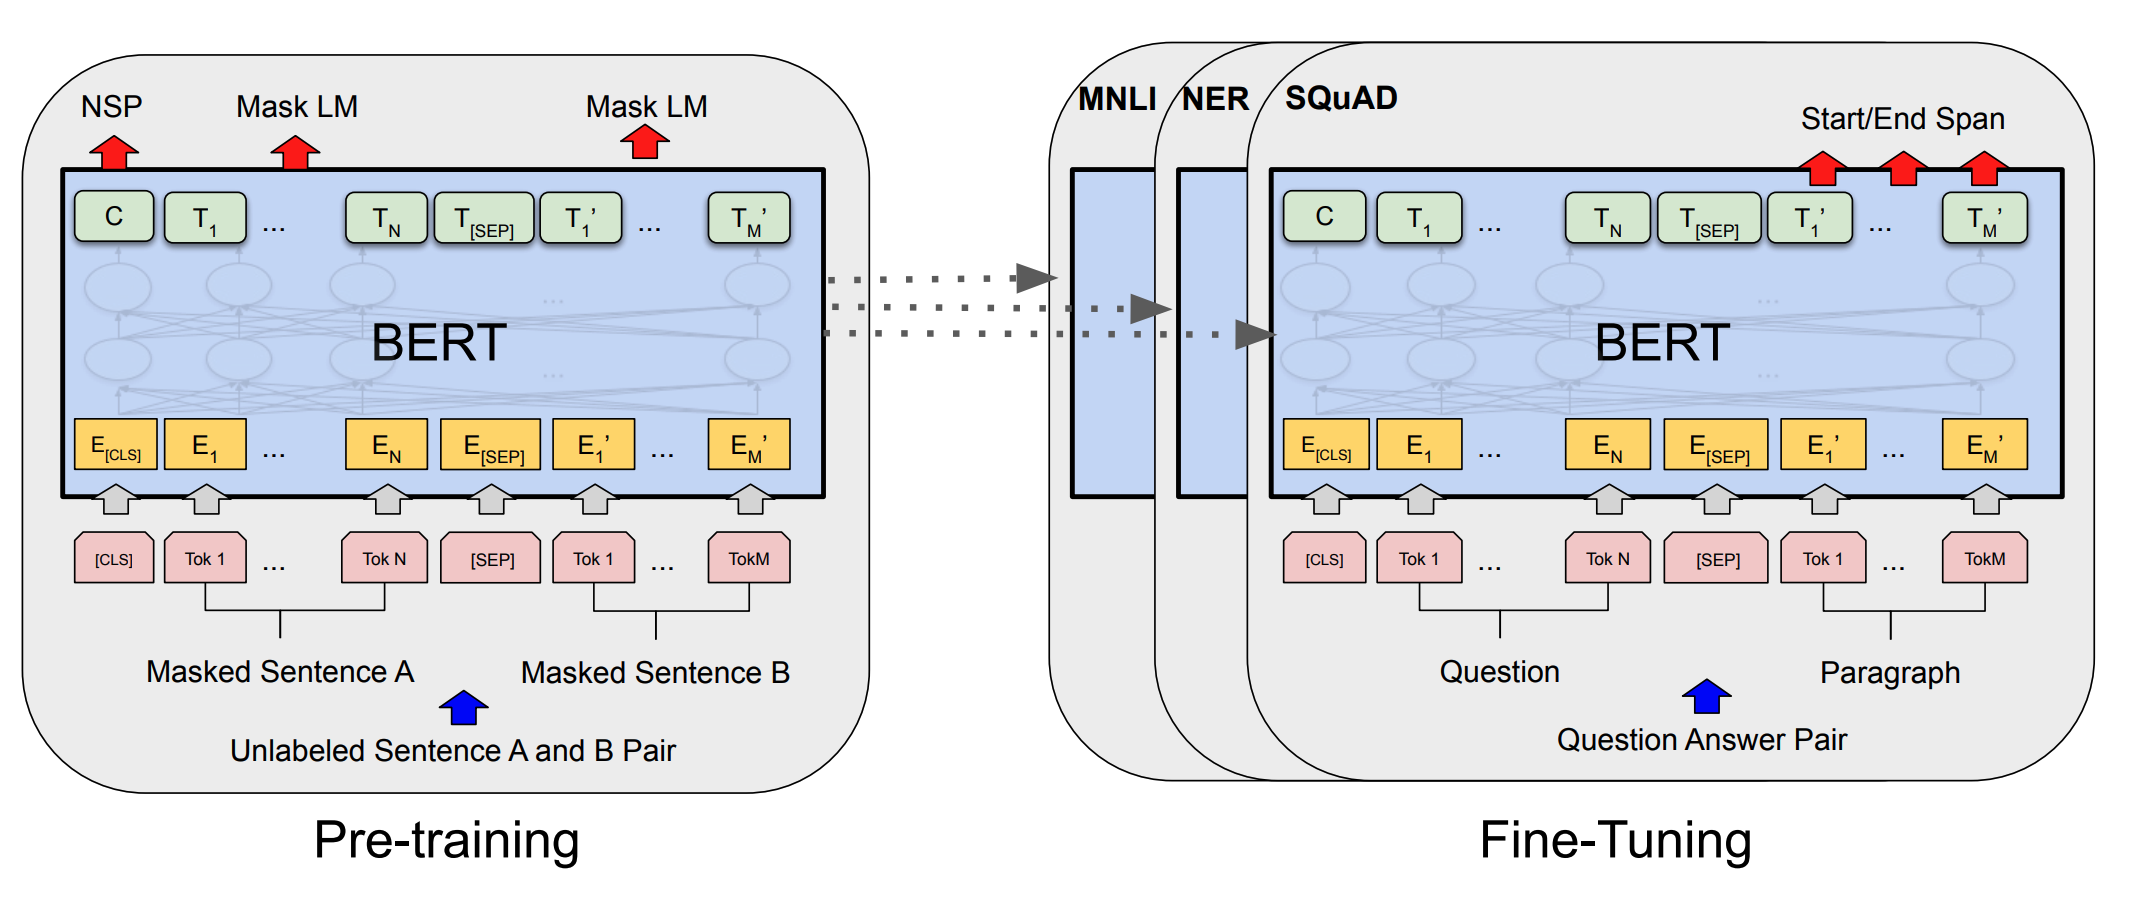


- `BERT` is a pretrained model that can be used for other tasks by doing `fine-tuning`
- The BERT consists of 12 TransformerEncoderLayers


Figure 1: Overall pre-training and fine-tuning procedures for BERT. Apart from output layers, the same architectures are used in both pre-training and fine-tuning. The same pre-trained model parameters are used to initialize
models for different down-stream tasks. During fine-tuning, all parameters are fine-tuned. [CLS] is a special
symbol added in front of every input example, and [SEP] is a special separator token (e.g. separating questions/answers).

### 2. Contextual Embedding
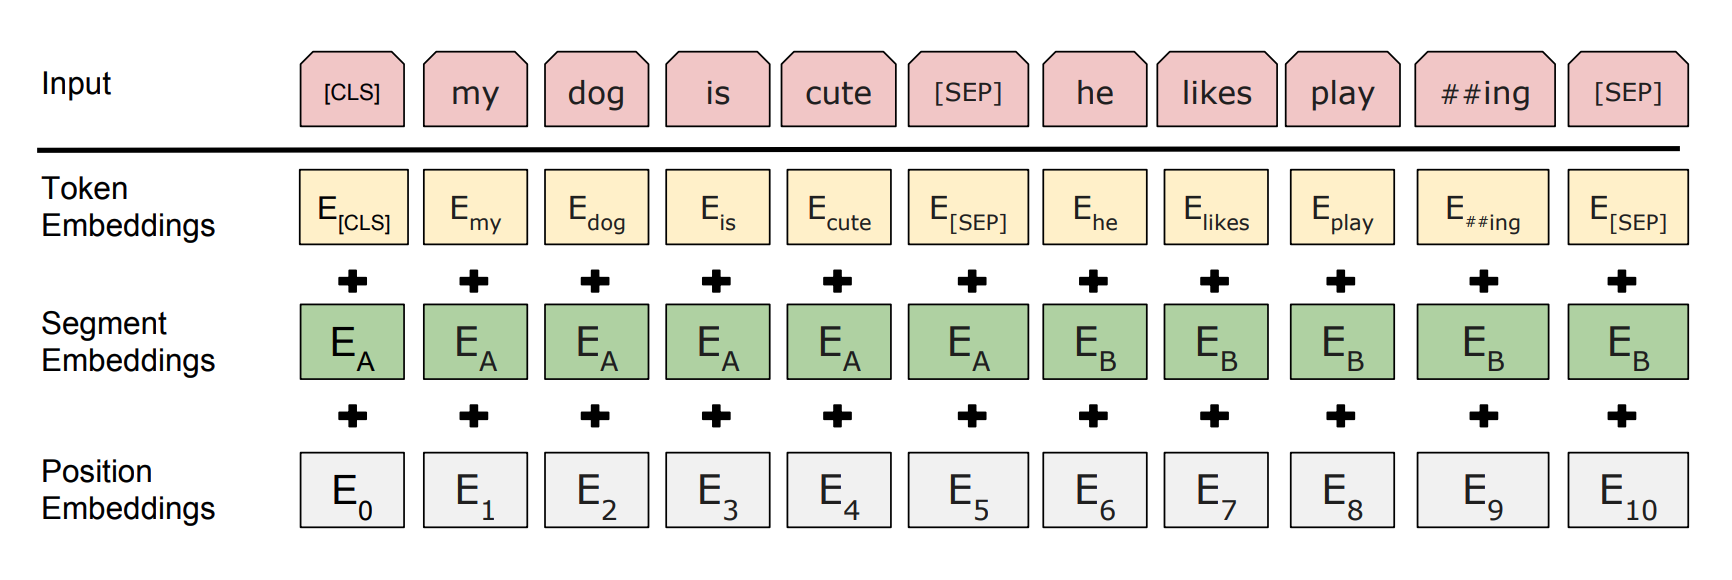
Figure 2: BERT input representation. The input embeddings are the sum of the token embeddings, the segmentation embeddings and the position embeddings.

### 3. Subword Tokenizer: WordPiece

In [1]:
import pandas as pd
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained("bert-base-uncased") # Bert-base의 토크나이저


/home/jgjang/anaconda3/envs/torch/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


The sentence `Here is the sentence I want embeddings for.` is tokenized to:

In [2]:
result = tokenizer.tokenize('Here is the sentence I want embeddings for.')
print(result)

['here', 'is', 'the', 'sentence', 'i', 'want', 'em', '##bed', '##ding', '##s', 'for', '.']


In the tokenized vector, the `embedding` does not exist in the vocabulary book.

Thus, the word is splited into three elements: `em`, `##bed`, `##ing`.
- For the sub-words except the first sub-word, `##` is attached in fron of the sub-words.

In [3]:
# token to int 
print(tokenizer.vocab['here'])


2182


In [4]:
# Save Vocabulary set to the vocabulary.txt
with open('vocabulary.txt', 'w') as f:
  for token in tokenizer.vocab.keys():
    f.write(token + '\n')
    
df = pd.read_fwf('vocabulary.txt', header=None)
df

,0
0,[PAD]
1,[unused0]
2,[unused1]
3,[unused2]
4,[unused3]
...,...
30517,##．
30518,##／
30519,##：
30520,##？


In [5]:
print('vocab. size :',len(df))

vocab. size : 30522


In [6]:
print(f'4667-th word is : {df.loc[4667].values[0]}')

4667-th word is : ##ding


Special tokens
- [PAD] - 0
- [UNK] - 100
- [CLS] - 101
- [SEP] - 102
- [MASK] - 103

### 4. Classification with BERT
source : [Link](https://zzaebok.github.io/deep_learning/nlp/Bert-for-classification/)

Classify positive and negative reviews on a Movie

In [7]:
# Import libraries
import numpy as np
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from pytorch_transformers import BertTokenizer, BertForSequenceClassification, BertConfig
from torch.optim import Adam
import torch.nn.functional as F

#### 4.1. Download dataset

In [8]:
#!git clone https://github.com/e9t/nsmc.git

fatal: destination path 'nsmc' already exists and is not an empty directory.


In [16]:
#Load the dataset
train_df = pd.read_csv('./nsmc/ratings_train.txt', sep='\t')
test_df = pd.read_csv('./nsmc/ratings_test.txt', sep='\t')
test_df.dropna(inplace=True)

train_df = train_df.sample(frac=0.4, random_state=999)
test_df = test_df.sample(frac=0.4, random_state=999)
test_df

,id,document,label
40821,10097178,명불허전 선동영화 10자,0
6654,9964664,사랑의 위대함과 아름다움을 완벽히 담아낸 영화 왜 이제 봤을까?,1
39722,9688343,보고나서 또 생각난다.,1
35661,7418688,아...진짜...,0
13250,6395675,난 이게 왜케 재밌었지..,1
...,...,...,...
23742,8684645,평점이 너무 높다 아무런 나레이션 설명없이 화면만 보여주는데 뭐 어쩌라는거지? 다큐...,0
28471,8187637,와진짜 영화가 이상해... 주제가 계속바뀜 그리고 개뜬금포로 키스하고...뭐야 이영화,0
16668,8848074,이건 보는 영화가 아니다.,0
20749,8652001,이기욱...내가 4천원내고 결재했는데 진짜...열받게하지마라,0


In [10]:
# Data Loader
class NsmcDataset(Dataset):
    ''' Naver Sentiment Movie Corpus Dataset '''
    def __init__(self, df):
        self.df = df

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        text = self.df.iloc[idx, 1]
        label = self.df.iloc[idx, 2]
        return text, label

In [11]:
nsmc_train_dataset = NsmcDataset(train_df)
train_loader = DataLoader(nsmc_train_dataset, batch_size=2, shuffle=True, num_workers=2)

#### 4.2. Use Pre-trained model
- `bert-base-multilingual-cased` model (pre-trained by Google)

In [17]:
device = torch.device("cuda")
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased')
model = BertForSequenceClassification.from_pretrained('bert-base-multilingual-cased').to(device)

### 5. Training

In [13]:
optimizer = Adam(model.parameters(), lr=1e-6)

itr = 1
p_itr = 500
epochs = 1
total_loss = 0
total_len = 0
total_correct = 0


model.train()
for epoch in range(epochs):
    
    for text, label in train_loader:
        optimizer.zero_grad()
        
        # encoding and zero padding
        encoded_list = [tokenizer.encode(t, add_special_tokens=True) for t in text]
        padded_list =  [e + [0] * (512-len(e)) for e in encoded_list]
        
        sample = torch.tensor(padded_list)
        sample, label = sample.to(device), label.to(device)
        labels = torch.tensor(label)
        outputs = model(sample, labels=labels)
        loss, logits = outputs

        pred = torch.argmax(F.softmax(logits), dim=1)
        correct = pred.eq(labels)
        total_correct += correct.sum().item()
        total_len += len(labels)
        total_loss += loss.item()
        loss.backward()
        optimizer.step()
        
        if itr % p_itr == 0:
            print('[Epoch {}/{}] Iteration {} -> Train Loss: {:.4f}, Accuracy: {:.3f}'.format(epoch+1, epochs, itr, total_loss/p_itr, total_correct/total_len))
            total_loss = 0
            total_len = 0
            total_correct = 0

        itr+=1

/tmp/ipykernel_868977/193746744.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(label)
/tmp/ipykernel_868977/193746744.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred = torch.argmax(F.softmax(logits), dim=1)


[Epoch 1/1] Iteration 500 -> Train Loss: 0.6927, Accuracy: 0.509
[Epoch 1/1] Iteration 1000 -> Train Loss: 0.6949, Accuracy: 0.539
[Epoch 1/1] Iteration 1500 -> Train Loss: 0.6908, Accuracy: 0.535
[Epoch 1/1] Iteration 2000 -> Train Loss: 0.6774, Accuracy: 0.580
[Epoch 1/1] Iteration 2500 -> Train Loss: 0.6881, Accuracy: 0.540
[Epoch 1/1] Iteration 3000 -> Train Loss: 0.6725, Accuracy: 0.598
[Epoch 1/1] Iteration 3500 -> Train Loss: 0.6470, Accuracy: 0.617
[Epoch 1/1] Iteration 4000 -> Train Loss: 0.6138, Accuracy: 0.673
[Epoch 1/1] Iteration 4500 -> Train Loss: 0.6118, Accuracy: 0.674
[Epoch 1/1] Iteration 5000 -> Train Loss: 0.5666, Accuracy: 0.721
[Epoch 1/1] Iteration 5500 -> Train Loss: 0.5910, Accuracy: 0.707
[Epoch 1/1] Iteration 6000 -> Train Loss: 0.5616, Accuracy: 0.723
[Epoch 1/1] Iteration 6500 -> Train Loss: 0.5673, Accuracy: 0.701
[Epoch 1/1] Iteration 7000 -> Train Loss: 0.5714, Accuracy: 0.704
[Epoch 1/1] Iteration 7500 -> Train Loss: 0.5685, Accuracy: 0.708
[Epoch 1/1]

KeyboardInterrupt: 

In [15]:
# evaluation
model.eval()

nsmc_eval_dataset = NsmcDataset(test_df)
eval_loader = DataLoader(nsmc_eval_dataset, batch_size=2, shuffle=False, num_workers=2)

total_loss = 0
total_len = 0
total_correct = 0

for text, label in eval_loader:
    encoded_list = [tokenizer.encode(t, add_special_tokens=True) for t in text]
    padded_list =  [e + [0] * (512-len(e)) for e in encoded_list]
    sample = torch.tensor(padded_list)
    sample, label = sample.to(device), label.to(device)
    labels = torch.tensor(label)
    outputs = model(sample, labels=labels)
    _, logits = outputs

    pred = torch.argmax(F.softmax(logits), dim=1)
    correct = pred.eq(labels)
    total_correct += correct.sum().item()
    total_len += len(labels)

print('Test accuracy: ', total_correct / total_len)

/tmp/ipykernel_868977/465935077.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(label)
/tmp/ipykernel_868977/465935077.py:20: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred = torch.argmax(F.softmax(logits), dim=1)


Test accuracy:  0.8031901595079755
